## Import Library

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize


from wordcloud import WordCloud

import pickle
import en_core_web_sm

from gensim.models import Word2Vec
from imblearn.over_sampling import SMOTE
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, auc

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.naive_bayes import MultinomialNB


import warnings
warnings.filterwarnings("ignore")

#Recommendation System required Lib.
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import LabelEncoder


## Data Load

In [2]:
df = pd.read_csv("Data/sample30.csv")
df.head()

,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_userCity,reviews_userProvince,reviews_username,user_sentiment
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Mo...",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30T06:21:45.000Z,NaN,NaN,5,i love this album. it's very good. more to the...,Just Awesome,Los Angeles,NaN,joshua,Positive
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor. This review was collected as part...,Good,NaN,NaN,dorothy w,Positive
2,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor.,Good,NaN,NaN,dorothy w,Positive
3,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-01-06T00:00:00.000Z,False,False,1,I read through the reviews on here before look...,Disappointed,NaN,NaN,rebecca,Negative
4,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-12-21T00:00:00.000Z,False,False,1,My husband bought this gel for us. The gel cau...,Irritation,NaN,NaN,walker557,Negative


# Task 1: Data Cleaning and Pre-Processing

### Missing Value Checks

In [3]:
df.isnull().sum()

id                          0
brand                       0
categories                  0
manufacturer              141
name                        0
reviews_date               46
reviews_didPurchase     14068
reviews_doRecommend      2570
reviews_rating              0
reviews_text                0
reviews_title             190
reviews_userCity        28071
reviews_userProvince    29830
reviews_username           63
user_sentiment              1
dtype: int64

In [4]:
df['reviews_doRecommend'].value_counts()

reviews_doRecommend
True     25880
False     1550
Name: count, dtype: int64

In [5]:
# Delete Columns whoes Missing value above 45%.
df=df.drop(['reviews_didPurchase', 'reviews_userCity', 'reviews_userProvince'], axis=1)
df.shape

(30000, 12)

In [6]:
df['user_sentiment'].value_counts(normalize=True)

user_sentiment
Positive    0.887763
Negative    0.112237
Name: proportion, dtype: float64

In [7]:
df[df['user_sentiment'].isnull()]

,id,brand,categories,manufacturer,name,reviews_date,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_username,user_sentiment
28354,AVpfRTh1ilAPnD_xYic2,Disney,"Movies, Music & Books,Movies,Kids' & Family,Wa...",Walt Disney,Planes: Fire Rescue (2 Discs) (includes Digita...,2014-11-07T00:00:00.000Z,True,5,my kids absolutely loved this film so much tha...,a super hit with my children. they loved it!!??,7.87E+11,NaN


In [8]:
#Fill missing Value for column user_sentiment

mask = df['user_sentiment'].isnull()
df['user_sentiment'].loc[mask] = df['reviews_rating'].loc[mask].apply(lambda rating:'Positive' if rating>3 else 'Negative')

In [9]:
df.loc[28354]

id                                                  AVpfRTh1ilAPnD_xYic2
brand                                                             Disney
categories             Movies, Music & Books,Movies,Kids' & Family,Wa...
manufacturer                                                 Walt Disney
name                   Planes: Fire Rescue (2 Discs) (includes Digita...
reviews_date                                    2014-11-07T00:00:00.000Z
reviews_doRecommend                                                 True
reviews_rating                                                         5
reviews_text           my kids absolutely loved this film so much tha...
reviews_title            a super hit with my children. they loved it!!??
reviews_username                                                7.87E+11
user_sentiment                                                  Positive
Name: 28354, dtype: object

## Feature Creation

In [10]:
df[['reviews_title','reviews_text']]

,reviews_title,reviews_text
0,Just Awesome,i love this album. it's very good. more to the...
1,Good,Good flavor. This review was collected as part...
2,Good,Good flavor.
3,Disappointed,I read through the reviews on here before look...
4,Irritation,My husband bought this gel for us. The gel cau...
...,...,...
29995,Softness!!,I got this conditioner with Influenster to try...
29996,I love it,"I love it , I received this for review purpose..."
29997,Hair is so smooth after use,First of all I love the smell of this product....
29998,Perfect for my oily hair!,I received this through Influenster and will n...


In [11]:
#Merge 2 clolumns reviews_title, reviews_text

df['reviews'] = df['reviews_title']+" "+df['reviews_text']
df.head()

,id,brand,categories,manufacturer,name,reviews_date,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_username,user_sentiment,reviews
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Mo...",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30T06:21:45.000Z,NaN,5,i love this album. it's very good. more to the...,Just Awesome,joshua,Positive,Just Awesome i love this album. it's very good...
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,NaN,5,Good flavor. This review was collected as part...,Good,dorothy w,Positive,Good Good flavor. This review was collected as...
2,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,NaN,5,Good flavor.,Good,dorothy w,Positive,Good Good flavor.
3,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-01-06T00:00:00.000Z,False,1,I read through the reviews on here before look...,Disappointed,rebecca,Negative,Disappointed I read through the reviews on her...
4,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-12-21T00:00:00.000Z,False,1,My husband bought this gel for us. The gel cau...,Irritation,walker557,Negative,Irritation My husband bought this gel for us. ...


# EDA

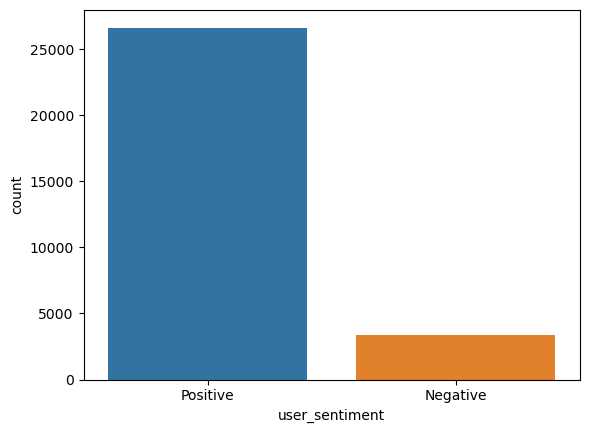

In [12]:
sns.countplot(x = 'user_sentiment', data = df)
plt.show()

## Data is Imbalanced, 88.7% is Positive and 11.22% is negative reviews.

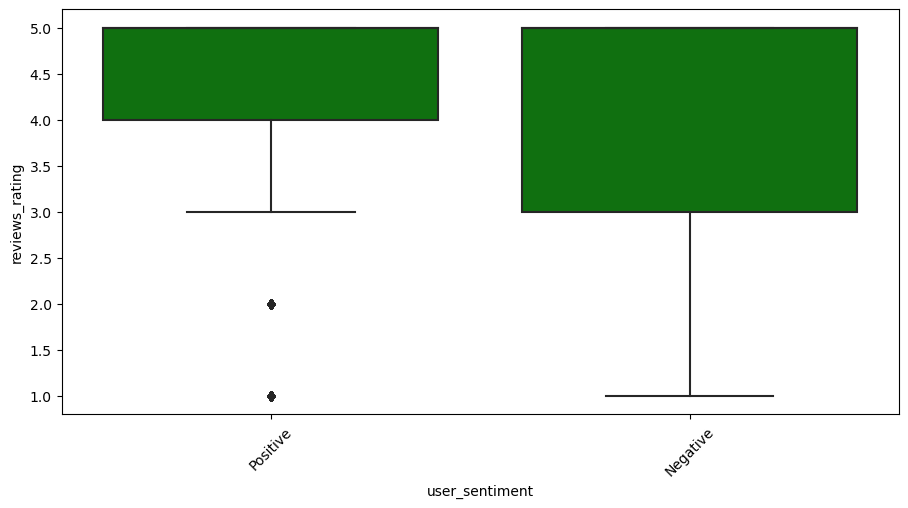

In [13]:
plt.figure(figsize = [10,6])

sns.boxplot(data=df, x='user_sentiment', y='reviews_rating', color='green')
plt.xticks(rotation = 45)

plt.tight_layout(pad = 4)
plt.show()

In [14]:
df[(df['reviews_rating']<3) & (df['user_sentiment']=='Positive')]

,id,brand,categories,manufacturer,name,reviews_date,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_username,user_sentiment,reviews
9,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-03-21T00:00:00.000Z,False,1,Got as a surprise for my husband there is noth...,Don't buy,moore222,Positive,Don't buy Got as a surprise for my husband the...
11,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-04-05T00:00:00.000Z,False,1,Purchased this thinking it would have some sor...,Waste of Money,bre234,Positive,Waste of Money Purchased this thinking it woul...
14,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-01-09T00:00:00.000Z,False,1,First time purchase of this type of product. M...,Disappointed,nicole,Positive,Disappointed First time purchase of this type ...
54,AV1l8zRZvKc47QAVhnAv,Olay,"Personal Care,Skin Care,Anti-Aging,Beauty,Face...",P&G,Olay Regenerist Deep Hydration Regenerating Cream,2014-09-01T00:00:00.000Z,False,1,I used (and loved) this product for several ye...,New formula is terrible,alnscoob97,Positive,New formula is terrible I used (and loved) thi...
56,AV1l8zRZvKc47QAVhnAv,Olay,"Personal Care,Skin Care,Anti-Aging,Beauty,Face...",P&G,Olay Regenerist Deep Hydration Regenerating Cream,2014-09-07T00:00:00.000Z,False,1,I am so disappointed! I have used this product...,Please bring back the old formula,jacmary,Positive,Please bring back the old formula I am so disa...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
28869,AVpfW8y_LJeJML437ySW,L'oreal Paris,"Beauty,Hair Care,Shampoo & Conditioner,Holiday...",L'oreal Paris,L'or233al Paris Elvive Extraordinary Clay Reba...,2017-01-30T19:52:26.000Z,NaN,2,This was the last step out of the three step p...,Last Step!,mmrowell,Positive,Last Step! This was the last step out of the t...
28870,AVpfW8y_LJeJML437ySW,L'oreal Paris,"Beauty,Hair Care,Shampoo & Conditioner,Holiday...",L'oreal Paris,L'or233al Paris Elvive Extraordinary Clay Reba...,2017-01-28T03:48:36.000Z,NaN,2,"I have been a big LOral fan, using their produ...","Unfortunately, Not For My Hair",rally16,Positive,"Unfortunately, Not For My Hair I have been a b..."
28871,AVpfW8y_LJeJML437ySW,L'oreal Paris,"Beauty,Hair Care,Shampoo & Conditioner,Holiday...",L'oreal Paris,L'or233al Paris Elvive Extraordinary Clay Reba...,2017-01-23T03:35:19.000Z,NaN,2,Despite using this with the line's hair mask a...,I Really Wanted To Love This But...,swess12,Positive,I Really Wanted To Love This But... Despite us...
28872,AVpfW8y_LJeJML437ySW,L'oreal Paris,"Beauty,Hair Care,Shampoo & Conditioner,Holiday...",L'oreal Paris,L'or233al Paris Elvive Extraordinary Clay Reba...,2017-01-21T07:14:35.000Z,NaN,2,I tried out this whole set.i wanted it to work...,Just Not For Me,spov,Positive,Just Not For Me I tried out this whole set.i w...


# Task 2: Text Preprocessing

In [15]:
df['reviews'] = df['reviews'].astype(str)
df_text = df[['id', 'name','reviews', 'user_sentiment']]


In [16]:
df_text.shape

(30000, 4)

### Duplicate check

In [17]:
df_text[df_text.duplicated()]

,id,name,reviews,user_sentiment
299,AV1l8zRZvKc47QAVhnAv,Olay Regenerist Deep Hydration Regenerating Cream,Regenerating Cream I loved this product. My sk...,Positive
770,AV1YGDqsGV-KLJ3adc-O,Windex Original Glass Cleaner Refill 67.6oz (2...,My Go-To Cleaner I carry this around with me e...,Positive
931,AV1YGDqsGV-KLJ3adc-O,Windex Original Glass Cleaner Refill 67.6oz (2...,Best Windex Original is the only glass cleaner...,Positive
1160,AV1YmDL9vKc47QAVgr7_,"Aussie Aussome Volume Shampoo, 13.5 Oz",Use daily This is my favorite shampoo. I have ...,Positive
1443,AVpe_dxlilAPnD_xSiHI,"The Seaweed Bath Co. Argan Conditioner, Smooth...",nan,Positive
...,...,...,...,...
29627,AVpfW8y_LJeJML437ySW,L'or233al Paris Elvive Extraordinary Clay Reba...,A Dream Come True For someone who has thin and...,Positive
29633,AVpfW8y_LJeJML437ySW,L'or233al Paris Elvive Extraordinary Clay Reba...,Soft! Soft! Soft! This conditioner isn't heavy...,Negative
29634,AVpfW8y_LJeJML437ySW,L'or233al Paris Elvive Extraordinary Clay Reba...,Great Conditioner! I received this complementa...,Positive
29638,AVpfW8y_LJeJML437ySW,L'or233al Paris Elvive Extraordinary Clay Reba...,Nice I received these products free/compliment...,Positive


In [18]:
### Remove duplicate
df_text = df_text.drop_duplicates()
df_text.shape

(29568, 4)

In [19]:
def clean_process(text):
  text = text.lower()
  text = re.sub(r'[^\w\s]', '', text)
  return text

In [20]:
df_text.loc[:,'clean_review'] = df_text['reviews'].apply(clean_process)
df_text.head()

,id,name,reviews,user_sentiment,clean_review
0,AV13O1A8GV-KLJ3akUyj,Pink Friday: Roman Reloaded Re-Up (w/dvd),Just Awesome i love this album. it's very good...,Positive,just awesome i love this album its very good m...
1,AV14LG0R-jtxr-f38QfS,Lundberg Organic Cinnamon Toast Rice Cakes,Good Good flavor. This review was collected as...,Positive,good good flavor this review was collected as ...
2,AV14LG0R-jtxr-f38QfS,Lundberg Organic Cinnamon Toast Rice Cakes,Good Good flavor.,Positive,good good flavor
3,AV16khLE-jtxr-f38VFn,K-Y Love Sensuality Pleasure Gel,Disappointed I read through the reviews on her...,Negative,disappointed i read through the reviews on her...
4,AV16khLE-jtxr-f38VFn,K-Y Love Sensuality Pleasure Gel,Irritation My husband bought this gel for us. ...,Negative,irritation my husband bought this gel for us t...


### Stop Word

In [21]:

nltk.download('stopwords')
nltk.download('punkt')

stopwords_set = set(stopwords.words("english"))

def stop_words(text):
  words = word_tokenize(text)
  words_nostopwords = " ".join([word for word in words if word not in stopwords_set])
  return words_nostopwords


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Rahul\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Rahul\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [22]:
df_text.loc[:,'nostopword_review'] = df_text['clean_review'].apply(stop_words)
df_text.head(2)

,id,name,reviews,user_sentiment,clean_review,nostopword_review
0,AV13O1A8GV-KLJ3akUyj,Pink Friday: Roman Reloaded Re-Up (w/dvd),Just Awesome i love this album. it's very good...,Positive,just awesome i love this album its very good m...,awesome love album good hip hop side current p...
1,AV14LG0R-jtxr-f38QfS,Lundberg Organic Cinnamon Toast Rice Cakes,Good Good flavor. This review was collected as...,Positive,good good flavor this review was collected as ...,good good flavor review collected part promotion


In [23]:
#Write your function to Lemmatize the texts
nlp = en_core_web_sm.load()

def lemmatize_preprocess(text):
  lemma_text = []
  document = nlp(text)
  for word in document:
    lemma_text.append(word.lemma_)

  return " ".join(lemma_text)

In [24]:
df_text.loc[:,'lema_review'] = df_text['nostopword_review'].apply(lemmatize_preprocess)
df_text.head(2)

,id,name,reviews,user_sentiment,clean_review,nostopword_review,lema_review
0,AV13O1A8GV-KLJ3akUyj,Pink Friday: Roman Reloaded Re-Up (w/dvd),Just Awesome i love this album. it's very good...,Positive,just awesome i love this album its very good m...,awesome love album good hip hop side current p...,awesome love album good hip hop side current p...
1,AV14LG0R-jtxr-f38QfS,Lundberg Organic Cinnamon Toast Rice Cakes,Good Good flavor. This review was collected as...,Positive,good good flavor this review was collected as ...,good good flavor review collected part promotion,good good flavor review collect part promotion


In [25]:
df_text = df_text[['id','name','lema_review','user_sentiment']]
df_text.head(2)

,id,name,lema_review,user_sentiment
0,AV13O1A8GV-KLJ3akUyj,Pink Friday: Roman Reloaded Re-Up (w/dvd),awesome love album good hip hop side current p...,Positive
1,AV14LG0R-jtxr-f38QfS,Lundberg Organic Cinnamon Toast Rice Cakes,good good flavor review collect part promotion,Positive


### Saving the cleaned dataframe

In [26]:
pickle.dump(df_text, open("./models/df_text.pkl","wb"))

In [27]:
df_clean = df_text[['lema_review', 'user_sentiment']]
df_clean.shape

(29568, 2)

In [28]:
df_clean.head()

,lema_review,user_sentiment
0,awesome love album good hip hop side current p...,Positive
1,good good flavor review collect part promotion,Positive
2,good good flavor,Positive
3,disappoint read review look buy one couple lub...,Negative
4,irritation husband buy gel us gel cause irrita...,Negative


## EDA to get familiar with the data.

visualise the data according to the 'review' character length


Text(0, 0.5, 'No. of reviews')

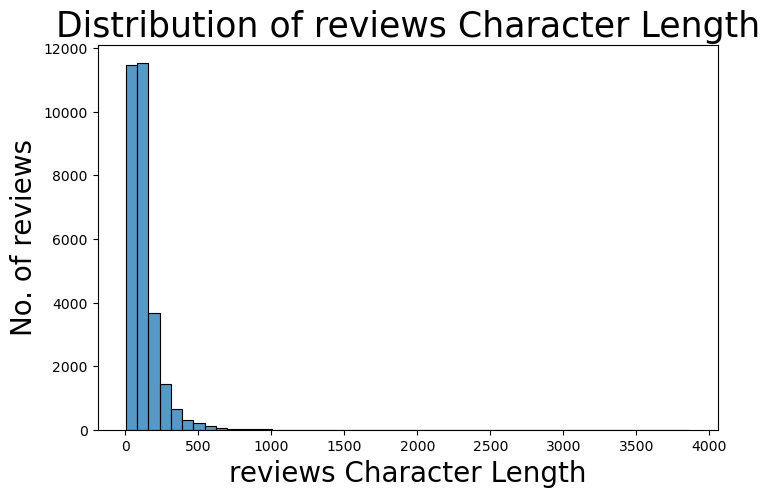

In [29]:
char_len=[len(x) for x in df_clean['lema_review']]
char_len[:10]

plt.figure(figsize=[8,5])
sns.histplot(data = char_len,bins=50)
plt.title('Distribution of reviews Character Length', fontsize=25)
plt.xlabel('reviews Character Length',size=20)
plt.ylabel('No. of reviews',size=20)

### Top 50 words by frequency among all the articles after processing the text.

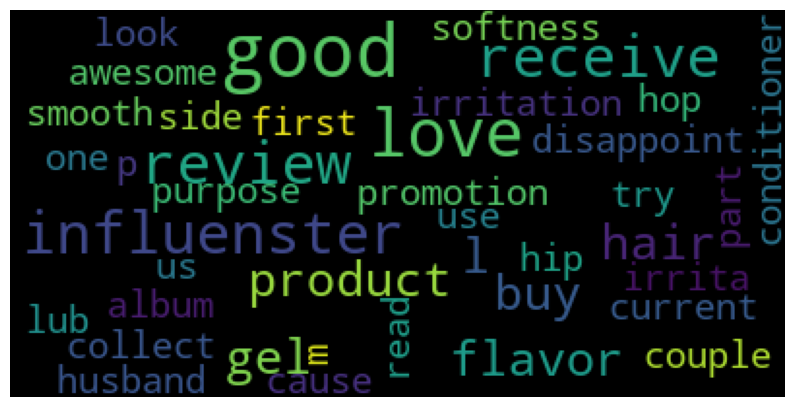

In [30]:
word_cloud = WordCloud(max_font_size=38, max_words=40, random_state=42 ).generate(str(df_clean['lema_review']))

fig = plt.figure(figsize=(10,6))
plt.imshow(word_cloud)
plt.axis('off')
plt.show()

## Convert Sentiment Columns into numeric

In [31]:
df_clean['user_sentiment_num'] = df_clean['user_sentiment'].map({'Negative':0,'Positive':1})
df_clean.head()

,lema_review,user_sentiment,user_sentiment_num
0,awesome love album good hip hop side current p...,Positive,1
1,good good flavor review collect part promotion,Positive,1
2,good good flavor,Positive,1
3,disappoint read review look buy one couple lub...,Negative,0
4,irritation husband buy gel us gel cause irrita...,Negative,0


# Task 3: Feature Extraction

## TfidfVectorizer

In [32]:
# tfidf = TfidfVectorizer(min_df=5, max_df=0.95, stop_words='english', ngram_range=(1,2))
# X = tfidf.fit_transform(df_clean['lema_review'])
# X.shape

In [33]:
tfidf = TfidfVectorizer()
X_tfidf = tfidf.fit_transform(df_clean['lema_review'])
X_tfidf.shape

(29568, 18643)

In [34]:
y= df_clean['user_sentiment_num']

In [35]:
# Saving the the tfidf vectorizer model
pickle.dump(tfidf, open("./models/tfidf.pkl","wb"))

# Word2Vec

In [36]:
# w2v_model = Word2Vec(df_clean['lema_review'],  window=5, min_count=1, workers=4)
# w2v_model



In [37]:

# # Create average word vectors for each review
# w2v_review_vectors = []
# for review in df_clean['lema_review']:
#     review_vector = np.zeros(w2v_model.vector_size)
#     count = 0
#     for word in review:
#         if word in w2v_model.wv:
#             review_vector += w2v_model.wv[word]
#             count += 1
#     if count != 0:
#         review_vector /= count
#     w2v_review_vectors.append(review_vector)

In [38]:
# len(w2v_review_vectors)

## Train Test Split

In [39]:
#X = w2v_review_vectors
X= X_tfidf

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.20)
#print("Train shapes:", X_train.shape, y_train.shape)
#print("Test shapes:", X_test.shape, y_test.shape)

## Class Imbalanced

In [41]:
y.value_counts(normalize=True)

user_sentiment_num
1    0.88748
0    0.11252
Name: proportion, dtype: float64

In [42]:
y_train.value_counts(normalize=True)

user_sentiment_num
1    0.886193
0    0.113807
Name: proportion, dtype: float64

## SMOTE
We are going to handle the imbalance using a technique called SMOTE (Synthetic Minority Oversampling Technique)
This is an oversampling method that generates synthetic samples for the minority class

In [43]:
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train,y_train)

#print("Train sm shapes:", X_train_sm.shape, y_train_sm.shape)

In [44]:
y_train_sm.value_counts(normalize=True)

user_sentiment_num
1    0.5
0    0.5
Name: proportion, dtype: float64

# Task 4: Model Building

### Evaluate Model Function

In [45]:
def evaluate_model(y_true, y_pred, model_name):
  print(f"Model: {model_name}")
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
  #fig, ax = plt.subplots(figsize=(3, 3))
  sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cbar=False, cmap="RdYlGn", fmt = '0.1f', ax=ax1)
  ax1.set_xlabel("Actual label")
  ax1.set_ylabel("Predicted label")
  ax1.set_title("Confusion Matrix")

  tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

  sensitivity = tp / (tp + fn)
  specificity = tn / (tn + fp)
  f1 = f1_score(y_true, y_pred)
  fpr, tpr, thresholds = roc_curve(y_true, y_pred)
  roc_auc = auc(fpr, tpr)

  # Plot ROC curve
  #plt.figure(figsize=(5, 3))
  ax2.plot(fpr, tpr, label=f"{model_name} (AUC = {roc_auc:.4f})")
  ax2.plot([0, 1], [0, 1], 'k--')
  ax2.set_xlabel("False Positive Rate")
  ax2.set_ylabel("True Positive Rate")
  ax2.set_title("ROC Curve")
  ax2.legend()

  plt.tight_layout()
  plt.show()

  return sensitivity, specificity, f1, roc_auc


## Mode l: - Logistic Regression

In [46]:
#Run the Logistic Regression model with default parameters
model_name = 'LOGISTIC REGRESSION'
lr = LogisticRegression()
lr.fit(X_train_sm, y_train_sm)
y_pred_lr = lr.predict(X_test)

f1_lr = f1_score(y_test, y_pred_lr)
f1_lr

0.916832867969685

Model: LOGISTIC REGRESSION


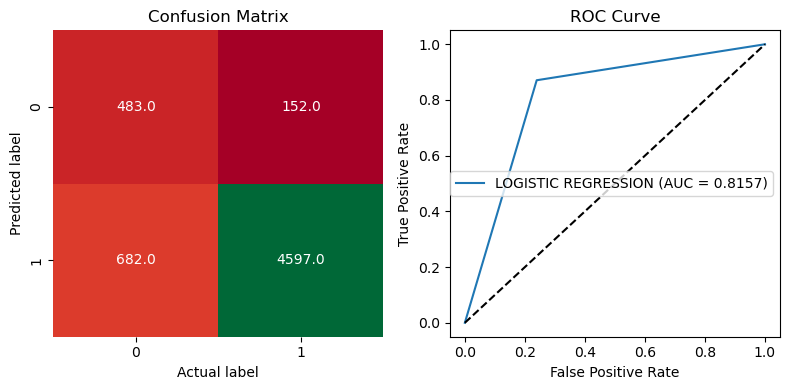

Sensitivity (Recall): 0.8708
Specificity: 0.7606
F1-score: 0.9168
AUC: 0.8157


In [47]:
sensitivity, specificity, f1, roc_auc = evaluate_model(y_test, y_pred_lr, model_name)
print(f"Sensitivity (Recall): {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"AUC: {roc_auc:.4f}")

In [48]:
# Create a dataframe to store F1 Scores of all models we will build
summary = pd.DataFrame([{'Model Name': 'Logistic Regression with default parameters','Sensitivity':round(sensitivity,3),'Specificity':round(specificity,3), 'AUC':round(roc_auc,3), 'F1 Score': round(f1_lr, 3) }])
summary

,Model Name,Sensitivity,Specificity,AUC,F1 Score
0,Logistic Regression with default parameters,0.871,0.761,0.816,0.917


In [49]:
# Hyperparameter tuning for best result
param_lr = {
    'penalty': ['l1', 'l2'],
    'C': [0.001,0.01,0.1,1,10,100],
    'solver':['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
}

grid_lr = GridSearchCV(estimator=lr, param_grid=param_lr, verbose=1, scoring='roc_auc', n_jobs=-1, cv=5)
grid_lr.fit(X_train_sm, y_train_sm)
print(grid_lr.best_params_)

Fitting 5 folds for each of 60 candidates, totalling 300 fits
{'C': 10, 'penalty': 'l2', 'solver': 'saga'}


In [50]:
lr_tuned = LogisticRegression(C=10, penalty= 'l2', solver= 'saga')
lr_tuned.fit(X_train_sm, y_train_sm)
y_pred_lr_tuned = lr_tuned.predict(X_test)

f1_lr_tuned = f1_score(y_test, y_pred_lr_tuned)
f1_lr_tuned

0.927459618208517

Model: LOGISTIC REGRESSION


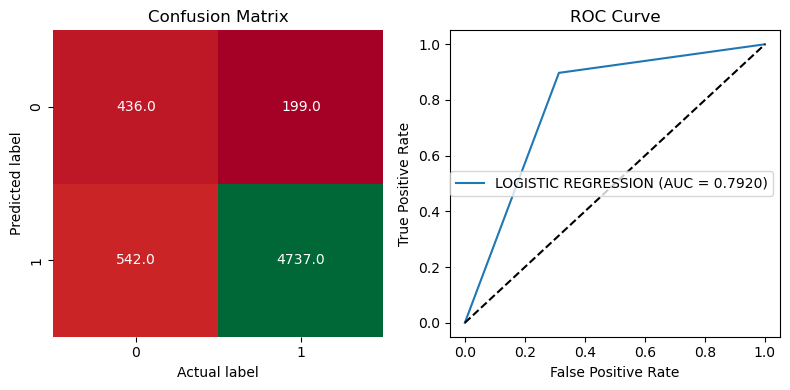

Sensitivity (Recall): 0.8973
Specificity: 0.6866
F1-score: 0.9275
AUC: 0.7920


In [51]:
sensitivity, specificity, f1, roc_auc = evaluate_model(y_test, y_pred_lr_tuned, model_name)
print(f"Sensitivity (Recall): {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"AUC: {roc_auc:.4f}")

In [52]:
# Update the summary table
summary.loc[len(summary.index)] = ['Logistic Regression best hyperparameters', round(sensitivity,3), round(specificity,3), round(roc_auc,3), round(f1_lr_tuned, 3)]
summary

,Model Name,Sensitivity,Specificity,AUC,F1 Score
0,Logistic Regression with default parameters,0.871,0.761,0.816,0.917
1,Logistic Regression best hyperparameters,0.897,0.687,0.792,0.927


### Mode 2: - Decision Tree

In [53]:
# Run Decision Tree with default hyperparameters
model_name = 'DECISION TREE'
dt = DecisionTreeClassifier()
dt.fit(X_train_sm, y_train_sm)
y_pred_dt =dt.predict(X_test)

# Calculate F1 Score of tuned model using weighted average method
f1_dt = f1_score(y_test, y_pred_dt)
f1_dt

0.9125757872090748

Model: DECISION TREE


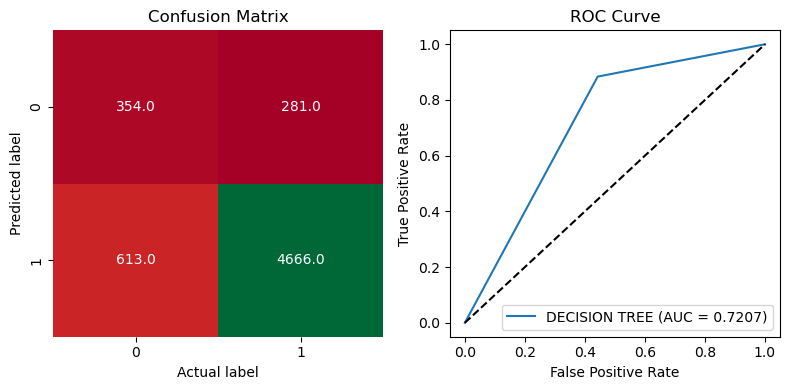

Sensitivity (Recall): 0.8839
Specificity: 0.5575
F1-score: 0.9126
AUC: 0.7207


In [54]:
sensitivity, specificity, f1, roc_auc = evaluate_model(y_test, y_pred_dt, model_name)
print(f"Sensitivity (Recall): {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"AUC: {roc_auc:.4f}")

In [55]:
# Update the summary table
summary.loc[len(summary.index)] = ['Decision Tree with default hyperparameters', round(sensitivity,3), round(specificity,3), round(roc_auc,3), round(f1_dt, 3)]
summary

,Model Name,Sensitivity,Specificity,AUC,F1 Score
0,Logistic Regression with default parameters,0.871,0.761,0.816,0.917
1,Logistic Regression best hyperparameters,0.897,0.687,0.792,0.927
2,Decision Tree with default hyperparameters,0.884,0.557,0.721,0.913


In [56]:
# Hyperparameter tuning for best result
param_dt = {
    'criterion': ['gini', 'entropy'],
    'max_depth' : [5, 10, 15, 20, 25, 30],
    'min_samples_leaf':[1,5,10,15, 20, 25],

}

grid_dt = GridSearchCV(estimator=dt,
                       param_grid=param_dt,
                       verbose=1,
                       scoring='roc_auc',
                       n_jobs=-1,
                       cv=3)
grid_dt.fit(X_train_sm, y_train_sm)
print(grid_dt.best_params_)

Fitting 3 folds for each of 72 candidates, totalling 216 fits
{'criterion': 'entropy', 'max_depth': 30, 'min_samples_leaf': 5}


In [57]:
# Run Decision Tree with default hyperparameters
model_name = 'DECISION TREE'
dt_tuned = DecisionTreeClassifier(criterion='entropy',max_depth = 30, min_samples_leaf=5)
dt_tuned.fit(X_train_sm, y_train_sm)
y_pred_dt_tuned =dt_tuned.predict(X_test)

# Calculate F1 Score of tuned model using weighted average method
f1_dt_tuned = f1_score(y_test, y_pred_dt_tuned)
f1_dt_tuned

0.8877048356288327

Model: DECISION TREE


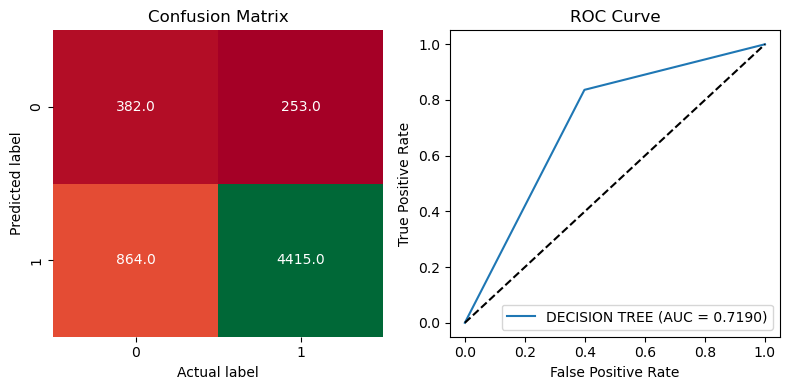

Sensitivity (Recall): 0.8363
Specificity: 0.6016
F1-score: 0.8877
AUC: 0.7190


In [58]:
sensitivity, specificity, f1, roc_auc = evaluate_model(y_test, y_pred_dt_tuned, model_name)
print(f"Sensitivity (Recall): {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"AUC: {roc_auc:.4f}")

In [59]:
# Update the summary table
summary.loc[len(summary.index)] = ['Decision Tree with best hyperparameters', round(sensitivity,3), round(specificity,3), round(roc_auc,3), round(f1_dt_tuned, 3)]
summary

,Model Name,Sensitivity,Specificity,AUC,F1 Score
0,Logistic Regression with default parameters,0.871,0.761,0.816,0.917
1,Logistic Regression best hyperparameters,0.897,0.687,0.792,0.927
2,Decision Tree with default hyperparameters,0.884,0.557,0.721,0.913
3,Decision Tree with best hyperparameters,0.836,0.602,0.719,0.888


## Mode 3: - Random Forest

In [60]:
#Run Random Forest with default hyperparameters

model_name = 'Random  Forest'
rf = RandomForestClassifier()
rf.fit(X_train_sm, y_train_sm)

y_pred_rf =rf.predict(X_test)

# Calculate F1 Score of tuned model using weighted average method
f1_rf = f1_score(y_test, y_pred_rf)
f1_rf

0.9446508172362557

Model: Random  Forest


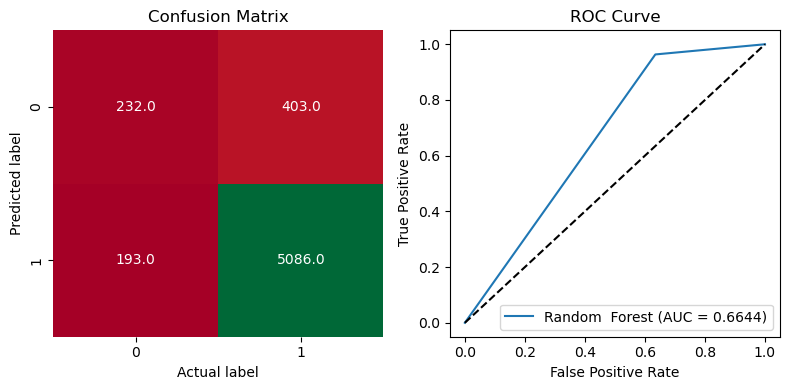

Sensitivity (Recall): 0.9634
Specificity: 0.3654
F1-score: 0.9447
AUC: 0.6644


In [61]:
sensitivity, specificity, f1, roc_auc = evaluate_model(y_test, y_pred_rf, model_name)
print(f"Sensitivity (Recall): {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"AUC: {roc_auc:.4f}")

In [62]:
# Update the summary table
summary.loc[len(summary.index)] = ['Random Forest with default hyperparameters', round(sensitivity,3), round(specificity,3), round(roc_auc,3), round(f1_rf, 3)]
summary

,Model Name,Sensitivity,Specificity,AUC,F1 Score
0,Logistic Regression with default parameters,0.871,0.761,0.816,0.917
1,Logistic Regression best hyperparameters,0.897,0.687,0.792,0.927
2,Decision Tree with default hyperparameters,0.884,0.557,0.721,0.913
3,Decision Tree with best hyperparameters,0.836,0.602,0.719,0.888
4,Random Forest with default hyperparameters,0.963,0.365,0.664,0.945


## Model 4:- XGBoost

In [63]:
model_name = 'XGBoost'
xgb = xgb.XGBClassifier()
xgb.fit(X_train_sm, y_train_sm)

y_pred_xgb = xgb.predict(X_test)

# Calculate F1 Score of tuned model using weighted average method
f1_xgb = f1_score(y_test, y_pred_xgb)
f1_xgb

0.9361579754601227

Model: XGBoost


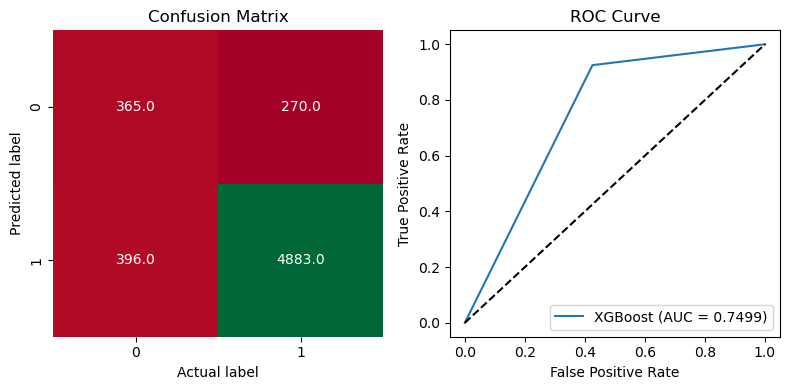

Sensitivity (Recall): 0.9250
Specificity: 0.5748
F1-score: 0.9362
AUC: 0.7499


In [64]:
sensitivity, specificity, f1, roc_auc = evaluate_model(y_test, y_pred_xgb, model_name)
print(f"Sensitivity (Recall): {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"AUC: {roc_auc:.4f}")

In [65]:
# Update the summary table
summary.loc[len(summary.index)] = ['XGBoost with default hyperparameters', round(sensitivity,3), round(specificity,3), round(roc_auc,3), round(f1_xgb, 3)]
summary

,Model Name,Sensitivity,Specificity,AUC,F1 Score
0,Logistic Regression with default parameters,0.871,0.761,0.816,0.917
1,Logistic Regression best hyperparameters,0.897,0.687,0.792,0.927
2,Decision Tree with default hyperparameters,0.884,0.557,0.721,0.913
3,Decision Tree with best hyperparameters,0.836,0.602,0.719,0.888
4,Random Forest with default hyperparameters,0.963,0.365,0.664,0.945
5,XGBoost with default hyperparameters,0.925,0.575,0.750,0.936


In [66]:
# import xgboost as xgb
# param_grid = {
#     'max_depth': [3, 5, 7],
#     'n_estimators': [100, 200, 300],
#     'learning_rate': [0.01, 0.05, 0.1],
#     'colsample_bytree': [0.6, 0.8, 1.0]
# }

# xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss')
# grid_search = GridSearchCV(xgb_model, param_grid, cv=2, scoring='f1', n_jobs=-1, verbose=1)
# grid_search.fit(X_train_sm, y_train_sm)
# best_params = grid_search.best_params_
# best_params


In [67]:
# xgb_final_model = xgb.XGBClassifier(**best_params)
# xgb_final_model.fit(X_train_sm, y_train_sm)

# y_pred_xgb = xgb_final_model.predict(X_test)

# # Calculate F1 Score of tuned model using weighted average method
# f1_xgb = f1_score(y_test, y_pred_xgb)
# f1_xgb

In [68]:
# sensitivity, specificity, f1, roc_auc = evaluate_model(y_test, y_pred_xgb, model_name)
# print(f"Sensitivity (Recall): {sensitivity:.4f}")
# print(f"Specificity: {specificity:.4f}")
# print(f"F1-score: {f1:.4f}")
# print(f"AUC: {roc_auc:.4f}")

In [69]:
# # Update the summary table
# summary.loc[len(summary.index)] = ['XGBoost with best hyperparameters', round(sensitivity,3), round(specificity,3), round(roc_auc,3), round(f1_xgb, 3)]
# summary

## Model 5:- Naive Bayes

In [70]:
# Run the Multinomial Naive Bayes with default parameters
model_name = 'NAIVE BAYES'
nb = MultinomialNB()
nb.fit(X_train_sm, y_train_sm)
y_pred_nb = nb.predict(X_test)


# Calculate F1 Score of tuned model using weighted average method
f1_nb = f1_score(y_test, y_pred_nb)
f1_nb

0.8912673802140643

Model: NAIVE BAYES


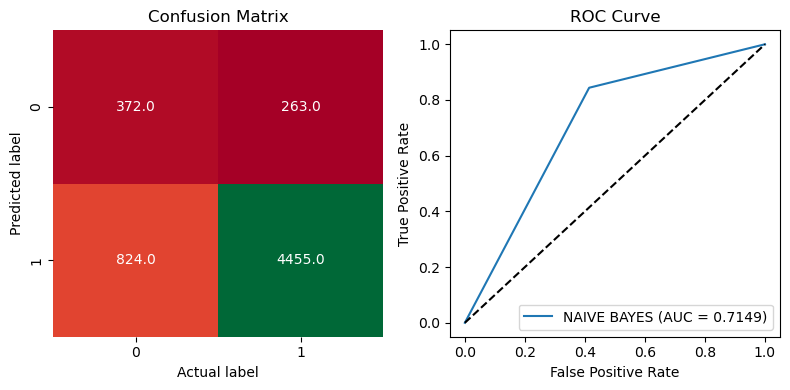

Sensitivity (Recall): 0.8439
Specificity: 0.5858
F1-score: 0.8913
AUC: 0.7149


In [71]:
sensitivity, specificity, f1, roc_auc = evaluate_model(y_test, y_pred_nb, model_name)
print(f"Sensitivity (Recall): {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"AUC: {roc_auc:.4f}")

In [72]:
# Update the summary table
summary.loc[len(summary.index)] = ['Naive Bayes with default parameters', round(sensitivity,3), round(specificity,3), round(roc_auc,3), round(f1_nb, 3)]
summary

,Model Name,Sensitivity,Specificity,AUC,F1 Score
0,Logistic Regression with default parameters,0.871,0.761,0.816,0.917
1,Logistic Regression best hyperparameters,0.897,0.687,0.792,0.927
2,Decision Tree with default hyperparameters,0.884,0.557,0.721,0.913
3,Decision Tree with best hyperparameters,0.836,0.602,0.719,0.888
4,Random Forest with default hyperparameters,0.963,0.365,0.664,0.945
5,XGBoost with default hyperparameters,0.925,0.575,0.750,0.936
6,Naive Bayes with default parameters,0.844,0.586,0.715,0.891


<b> Logistic Regression with default parameters: </b> This model has high sensitivity and specificity, with a good F1 score and AUC. It performs consistently well across multiple metrics.

<b> Logistic Regression best hyperparameters:</b>  While sensitivity is slightly higher compared to the default parameters, specificity, AUC, and F1 score are slightly lower. It might not be significantly better than the default model.

<b> Decision Tree with default hyperparameters:</b> While it has high sensitivity, it suffers from low specificity, which means it might have more false positives. Its AUC and F1 score are also comparatively lower.

<b> Random Forest with default hyperparameters:</b> This model has the highest sensitivity but very low specificity, indicating it might be overfitting the data. Its AUC and F1 score are decent but not the highest.


<b> XGBoost with default hyperparameters:</b> It has a good balance between sensitivity and specificity, with decent AUC and F1 score.

<b> XGBoost with best hyperparameters:</b> It shows slight improvement over the default hyperparameters in terms of sensitivity and specificity, with a slightly better F1 score and AUC. (Commented out during final execution due to high execution time.)

<b> Naive Bayes with default parameters:</b> While it has decent sensitivity, its specificity is relatively low compared to other models, leading to a lower F1 score and AUC.

Considering these metrics, <b>Logistic Regression with default parameters</b> seems to be the best choice for our sentiment-based recommendation model.

## Saving Best Model

In [73]:
pickle.dump(lr, open('./models/lr_base_model.pkl', 'wb'))

# Task 5: Building a Recommendation System

1. Split the data set into train and test data set for the recommendation system

2. Built at least two types of recommendation systems:
  - User-based recommendation systems
  - Item-based recommendation systems

3. Evaluated both the types of recommendation systems and selected one based on performance.

## Data Preprocessing

In [74]:
df_rec = df[["id", "name", "reviews_rating", "reviews_username"]]
df_rec

,id,name,reviews_rating,reviews_username
0,AV13O1A8GV-KLJ3akUyj,Pink Friday: Roman Reloaded Re-Up (w/dvd),5,joshua
1,AV14LG0R-jtxr-f38QfS,Lundberg Organic Cinnamon Toast Rice Cakes,5,dorothy w
2,AV14LG0R-jtxr-f38QfS,Lundberg Organic Cinnamon Toast Rice Cakes,5,dorothy w
3,AV16khLE-jtxr-f38VFn,K-Y Love Sensuality Pleasure Gel,1,rebecca
4,AV16khLE-jtxr-f38VFn,K-Y Love Sensuality Pleasure Gel,1,walker557
...,...,...,...,...
29995,AVpfW8y_LJeJML437ySW,L'or233al Paris Elvive Extraordinary Clay Reba...,5,laurasnchz
29996,AVpfW8y_LJeJML437ySW,L'or233al Paris Elvive Extraordinary Clay Reba...,5,scarlepadilla
29997,AVpfW8y_LJeJML437ySW,L'or233al Paris Elvive Extraordinary Clay Reba...,5,liviasuexo
29998,AVpfW8y_LJeJML437ySW,L'or233al Paris Elvive Extraordinary Clay Reba...,5,ktreed95


### Missing Value

In [75]:
df_rec.isnull().sum()


id                   0
name                 0
reviews_rating       0
reviews_username    63
dtype: int64

In [76]:
df_rec.shape

(30000, 4)

In [77]:
#Remove rows where data is missing
df_rec = df_rec[~ df_rec.reviews_username.isna() ]
df_rec.shape

(29937, 4)

In [78]:
#Check Uniquenes
print("Unique Id", len(df_rec['id'].unique()))
print("Unique Name", len(df_rec['name'].unique()))
print("Unique User Name", len(df_rec['reviews_username'].unique()))


Unique Id 271
Unique Name 271
Unique User Name 24914


In [79]:
df_rec[df_rec['id'] == 'AV14LG0R-jtxr-f38QfS']

,id,name,reviews_rating,reviews_username
1,AV14LG0R-jtxr-f38QfS,Lundberg Organic Cinnamon Toast Rice Cakes,5,dorothy w
2,AV14LG0R-jtxr-f38QfS,Lundberg Organic Cinnamon Toast Rice Cakes,5,dorothy w


### Duplicate Check

In [80]:
# Duplicate Check
df_rec[df_rec.duplicated()]

,id,name,reviews_rating,reviews_username
2,AV14LG0R-jtxr-f38QfS,Lundberg Organic Cinnamon Toast Rice Cakes,5,dorothy w
12,AV16khLE-jtxr-f38VFn,K-Y Love Sensuality Pleasure Gel,1,jds1992
44,AV1h6Gu0glJLPUi8IjA_,"Johnson's Baby Bubble Bath and Wash, 15oz",4,solo
79,AV1l8zRZvKc47QAVhnAv,Olay Regenerist Deep Hydration Regenerating Cream,3,mylifeinheels
90,AV1l8zRZvKc47QAVhnAv,Olay Regenerist Deep Hydration Regenerating Cream,3,mylifeinheels
...,...,...,...,...
29807,AVpfW8y_LJeJML437ySW,L'or233al Paris Elvive Extraordinary Clay Reba...,5,joycakes
29827,AVpfW8y_LJeJML437ySW,L'or233al Paris Elvive Extraordinary Clay Reba...,5,emily95
29841,AVpfW8y_LJeJML437ySW,L'or233al Paris Elvive Extraordinary Clay Reba...,5,brookieboo1994
29921,AVpfW8y_LJeJML437ySW,L'or233al Paris Elvive Extraordinary Clay Reba...,5,talmariejohn


In [81]:
# Remove duplicate rows
df_rec_unique = df_rec.drop_duplicates()

In [82]:
print("Unique Id", len(df_rec_unique['id'].unique()))
print("Unique Name", len(df_rec_unique['name'].unique()))
print("Unique User Name", len(df_rec_unique['reviews_username'].unique()))
print(df_rec_unique.shape)

Unique Id 271
Unique Name 271
Unique User Name 24914
(27739, 4)


In [83]:
df_rec_unique['reviews_username'].value_counts()

reviews_username
mike          23
chris         18
lisa          15
rick          14
sandy         13
              ..
ald80          1
cilly          1
firstchild     1
anniep         1
kcoopxoxo      1
Name: count, Length: 24914, dtype: int64

In [84]:
df_rec_unique[df_rec_unique['reviews_username']=='chris']

,id,name,reviews_rating,reviews_username
880,AV1YGDqsGV-KLJ3adc-O,Windex Original Glass Cleaner Refill 67.6oz (2...,5,chris
1608,AVpe31o71cnluZ0-YrSD,Dark Shadows (includes Digital Copy) (ultravio...,4,chris
1705,AVpe31o71cnluZ0-YrSD,Dark Shadows (includes Digital Copy) (ultravio...,5,chris
1835,AVpe41TqilAPnD_xQH3d,Mike Dave Need Wedding Dates (dvd + Digital),3,chris
2126,AVpe41TqilAPnD_xQH3d,Mike Dave Need Wedding Dates (dvd + Digital),4,chris
2388,AVpe41TqilAPnD_xQH3d,Mike Dave Need Wedding Dates (dvd + Digital),5,chris
3130,AVpe59io1cnluZ0-ZgDU,My Big Fat Greek Wedding 2 (blu-Ray + Dvd + Di...,5,chris
4614,AVpf0eb2LJeJML43EVSt,The Resident Evil Collection 5 Discs (blu-Ray),4,chris
4759,AVpf0eb2LJeJML43EVSt,The Resident Evil Collection 5 Discs (blu-Ray),5,chris
6395,AVpf385g1cnluZ0-s0_t,"Hormel Chili, No Beans",5,chris


### Aggregate Rating
I saw few user has rated products multiple times. Lets Aggregate rating

In [85]:
df_rec_group = df_rec_unique.groupby(['reviews_username', 'id','name']).agg({'reviews_rating': 'mean'}).reset_index()
df_rec_group

,reviews_username,id,name,reviews_rating
0,00dog3,AVpe6FfKilAPnD_xQmHi,Chex Muddy Buddies Brownie Supreme Snack Mix,4.0
1,00sab00,AVpe41TqilAPnD_xQH3d,Mike Dave Need Wedding Dates (dvd + Digital),1.0
2,00sab00,AVpe59io1cnluZ0-ZgDU,My Big Fat Greek Wedding 2 (blu-Ray + Dvd + Di...,3.0
3,01impala,AVpfPaoqLJeJML435Xk9,Godzilla 3d Includes Digital Copy Ultraviolet ...,3.0
4,02dakota,AVpfPaoqLJeJML435Xk9,Godzilla 3d Includes Digital Copy Ultraviolet ...,5.0
...,...,...,...,...
27583,zxcsdfd,AVpf3VOfilAPnD_xjpun,Clorox Disinfecting Wipes Value Pack Scented 1...,5.0
27584,zxjki,AVpf3VOfilAPnD_xjpun,Clorox Disinfecting Wipes Value Pack Scented 1...,2.0
27585,zyiah4,AVpf3VOfilAPnD_xjpun,Clorox Disinfecting Wipes Value Pack Scented 1...,5.0
27586,zzdiane,AVpe59io1cnluZ0-ZgDU,My Big Fat Greek Wedding 2 (blu-Ray + Dvd + Di...,5.0


## Train Test Split

In [86]:
train, test = train_test_split(df_rec_group, test_size=0.30, random_state=42)
print(train.shape)
print(test.shape)

(19311, 4)
(8277, 4)


## 1. User-based recommendation system:

In [87]:
# # Encode categorical variables
# encoder = LabelEncoder()
# train['username_id'] = encoder.fit_transform(train['reviews_username'])
# train['item_id'] = encoder.fit_transform(train['name'])



In [88]:
# Pivot the train ratings' dataset into matrix format in which columns are product and the rows are user name.
df_pivot = train.pivot(
    index='reviews_username',
    columns='id',
    values='reviews_rating'
).fillna(0)

df_pivot.head(3)

id,AV13O1A8GV-KLJ3akUyj,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YIch7GV-KLJ3addeG,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,...,AVpfr5cb1cnluZ0-pZFp,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfs0tUilAPnD_xgqN2,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpfv4TlilAPnD_xhjNS,AVpfvieo1cnluZ0-qdnu
reviews_username,,,,,,,,,,,,,,,,,,,,,
00dog3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00sab00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
02dakota,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [89]:
df_pivot.shape

(17878, 252)

### Creating dummy train & dummy test dataset

In [90]:
# Copy the train dataset into dummy_train
dummy_train = train.copy()
dummy_train.head()

,reviews_username,id,name,reviews_rating
9934,handyguy,AVpfNc9cLJeJML434tza,Feit 60-Watt A19 Gu24 Base Led Light Bulb - So...,2.0
11817,jes85,AVpe9W4D1cnluZ0-avf0,Hoover174 Platinum Collection153 Lightweight B...,5.0
13573,kdenreyes,AVpf3VOfilAPnD_xjpun,Clorox Disinfecting Wipes Value Pack Scented 1...,5.0
12074,jimbojack123,AVpfPnrU1cnluZ0-g9rL,Stargate (ws) (ultimate Edition) (director's C...,4.0
6203,critrkrazy,AVpe6n2_LJeJML43yOgE,Tresemme Kertatin Smooth Infusing Conditioning,5.0


In [91]:
# The reviews not rated by user is marked as 1 for prediction.
dummy_train['reviews_rating'] = dummy_train['reviews_rating'].apply(lambda x: 0 if x>=1 else 1)

In [92]:
# Convert the dummy train dataset into matrix format.
dummy_train = dummy_train.pivot(
    index='reviews_username',
    columns='id',
    values='reviews_rating'
).fillna(1)

In [93]:
dummy_train.head()

id,AV13O1A8GV-KLJ3akUyj,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YIch7GV-KLJ3addeG,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,...,AVpfr5cb1cnluZ0-pZFp,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfs0tUilAPnD_xgqN2,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpfv4TlilAPnD_xhjNS,AVpfvieo1cnluZ0-qdnu
reviews_username,,,,,,,,,,,,,,,,,,,,,
00dog3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
00sab00,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
02dakota,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
02deuce,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
08dallas,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


### User Similarity Matrix

### Using Cosine Similarity

In [94]:
# Creating the User Similarity Matrix using pairwise_distance function.
user_correlation = 1 - pairwise_distances(df_pivot, metric='cosine')
user_correlation[np.isnan(user_correlation)] = 0
#print(user_correlation)

In [95]:
user_correlation.shape

(17878, 17878)

### Using adjusted Cosine

Here, we are not removing the NaN values and calculating the mean only for the product rated by the user

In [96]:
# Create a user-movie matrix.
df_pivot = train.pivot(
    index='reviews_username',
    columns='id',
    values='reviews_rating'
)

In [97]:
df_pivot.head()

id,AV13O1A8GV-KLJ3akUyj,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YIch7GV-KLJ3addeG,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,...,AVpfr5cb1cnluZ0-pZFp,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfs0tUilAPnD_xgqN2,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpfv4TlilAPnD_xhjNS,AVpfvieo1cnluZ0-qdnu
reviews_username,,,,,,,,,,,,,,,,,,,,,
00dog3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
00sab00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
02dakota,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
02deuce,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
08dallas,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Normalising the rating of the product for each user around 0 mean

In [98]:
mean = np.nanmean(df_pivot, axis=1)
df_subtracted = (df_pivot.T-mean).T

In [99]:
df_subtracted.head()

id,AV13O1A8GV-KLJ3akUyj,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YIch7GV-KLJ3addeG,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,...,AVpfr5cb1cnluZ0-pZFp,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfs0tUilAPnD_xgqN2,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpfv4TlilAPnD_xhjNS,AVpfvieo1cnluZ0-qdnu
reviews_username,,,,,,,,,,,,,,,,,,,,,
00dog3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
00sab00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
02dakota,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
02deuce,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
08dallas,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Finding cosine similarity

In [100]:
# Creating the User Similarity Matrix using pairwise_distance function.
user_correlation = 1 - pairwise_distances(df_subtracted.fillna(0), metric='cosine')
user_correlation[np.isnan(user_correlation)] = 0
print(user_correlation)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


### Prediction - User User

Doing the prediction for the users which are positively related with other users, and not the users which are negatively related as we are interested in the users which are more similar to the current users. So, ignoring the correlation for values less than 0.

In [101]:
user_correlation[user_correlation<0]=0
user_correlation

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

Rating predicted by the user (for product rated as well as not rated) is the weighted sum of correlation with the product rating (as present in the rating dataset).

In [102]:
user_predicted_ratings = np.dot(user_correlation, df_pivot.fillna(0))
user_predicted_ratings

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 3.7326139 , 0.79056942,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [103]:
user_predicted_ratings.shape

(17878, 252)

Since we are interested only in the product not rated by the user, we will ignore the product rated by the user by making it zero.

In [104]:
user_final_rating = np.multiply(user_predicted_ratings,dummy_train)
user_final_rating.head()

id,AV13O1A8GV-KLJ3akUyj,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YIch7GV-KLJ3addeG,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,...,AVpfr5cb1cnluZ0-pZFp,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfs0tUilAPnD_xgqN2,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpfv4TlilAPnD_xhjNS,AVpfvieo1cnluZ0-qdnu
reviews_username,,,,,,,,,,,,,,,,,,,,,
00dog3,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0
00sab00,0.0,0.0,0.0,1.865069,0.0,0.0,0.0,0.0,2.581989,1.018079,...,0.0,6.265229,0.0,0.0,0.0,1.232614,0.0,3.732614,0.790569,0.0
02dakota,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0
02deuce,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0
08dallas,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0


#### Finding the top 20 recommendation for the user

In [105]:
user_final_rating.index

Index(['00dog3', '00sab00', '02dakota', '02deuce', '08dallas', '09mommy11',
       '1.11E+24', '1085', '10ten', '11111111aaaaaaaaaaaaaaaaa',
       ...
       'zsazsa', 'zt313', 'zubb', 'zulaa118', 'zuttle', 'zwithanx', 'zxcsdfd',
       'zxjki', 'zzdiane', 'zzz1127'],
      dtype='object', name='reviews_username', length=17878)

In [106]:
# Take the user ID as input.
user_input =  '00sab00'      #input("Enter your user name")
print(user_input)

00sab00


In [107]:
d = user_final_rating.loc[user_input].sort_values(ascending=False)[0:20]
d

id
AVpfPaoqLJeJML435Xk9    44.303274
AVpfRTh1ilAPnD_xYic2    30.135174
AVpf2tw1ilAPnD_xjflC    14.404380
AVpf0eb2LJeJML43EVSt    12.304630
AVpf3VOfilAPnD_xjpun     8.146628
AVpfM_ytilAPnD_xXIJb     7.769878
AVpe31o71cnluZ0-YrSD     7.475784
AVpfrFDZLJeJML43Bmv0     6.265229
AVpf385g1cnluZ0-s0_t     5.612668
AVpfPnrU1cnluZ0-g9rL     5.561432
AVpfR5m0LJeJML436K3W     5.327197
AVpf63aJLJeJML43F__Q     5.145497
AVpfOIrkilAPnD_xXgDG     3.996202
AVpf0thK1cnluZ0-r8vR     3.766386
AVpftikC1cnluZ0-p31V     3.732614
AVpfcu821cnluZ0-k8ep     3.307189
AVpfRoqcLJeJML436FqG     3.307189
AVpfJcHuLJeJML433ZrY     3.061862
AVpe4hlXLJeJML43xbrB     2.958040
AVpe_pDG1cnluZ0-bjSf     2.766993
Name: 00sab00, dtype: float64

In [108]:
merge_d = pd.merge(d,df_rec, left_on='id',right_on='id', how = 'left')
merge_d.head()

,id,00sab00,name,reviews_rating,reviews_username
0,AVpfPaoqLJeJML435Xk9,44.303274,Godzilla 3d Includes Digital Copy Ultraviolet ...,1,primoconcept
1,AVpfPaoqLJeJML435Xk9,44.303274,Godzilla 3d Includes Digital Copy Ultraviolet ...,1,terrym
2,AVpfPaoqLJeJML435Xk9,44.303274,Godzilla 3d Includes Digital Copy Ultraviolet ...,1,mrme
3,AVpfPaoqLJeJML435Xk9,44.303274,Godzilla 3d Includes Digital Copy Ultraviolet ...,1,3dknights
4,AVpfPaoqLJeJML435Xk9,44.303274,Godzilla 3d Includes Digital Copy Ultraviolet ...,1,master


In [109]:
merge_d.shape

(17350, 5)

### Evaluation - User User

Evaluation will we same as you have seen above for the prediction. The only difference being, you will evaluate for the movie already rated by the user insead of predicting it for the movie not rated by the user.

In [110]:
# Find out the common users of test and train dataset.
common = test[test.reviews_username.isin(train.reviews_username)]
common.shape

(1099, 4)

In [111]:
common.head()

,reviews_username,id,name,reviews_rating
6593,dani,AVpf2tw1ilAPnD_xjflC,Red (special Edition) (dvdvideo),5.0
12463,john,AVpf0eb2LJeJML43EVSt,The Resident Evil Collection 5 Discs (blu-Ray),4.0
10935,jack,AVpf99c6LJeJML43Gu3K,Romantic Drama: Greatest Classic Films Collect...,5.0
11072,james,AVpf2tw1ilAPnD_xjflC,Red (special Edition) (dvdvideo),4.0
17342,mhayser,AVpf3VOfilAPnD_xjpun,Clorox Disinfecting Wipes Value Pack Scented 1...,5.0


In [112]:
# convert into the user-movie matrix.
common_user_based_matrix = common.pivot_table(index='reviews_username', columns='id', values='reviews_rating')

In [113]:
# Convert the user_correlation matrix into dataframe.
user_correlation_df = pd.DataFrame(user_correlation)

In [114]:
df_subtracted.head(1)

id,AV13O1A8GV-KLJ3akUyj,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YIch7GV-KLJ3addeG,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,...,AVpfr5cb1cnluZ0-pZFp,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfs0tUilAPnD_xgqN2,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpfv4TlilAPnD_xhjNS,AVpfvieo1cnluZ0-qdnu
reviews_username,,,,,,,,,,,,,,,,,,,,,
00dog3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [115]:
user_correlation_df['reviews_username'] = df_subtracted.index
user_correlation_df.set_index('reviews_username',inplace=True)
user_correlation_df.head()

,0,1,2,3,4,5,6,7,8,9,...,17868,17869,17870,17871,17872,17873,17874,17875,17876,17877
reviews_username,,,,,,,,,,,,,,,,,,,,,
00dog3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00sab00,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
02dakota,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
02deuce,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
08dallas,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [116]:
common.head(1)

,reviews_username,id,name,reviews_rating
6593,dani,AVpf2tw1ilAPnD_xjflC,Red (special Edition) (dvdvideo),5.0


In [117]:
list_name = common.reviews_username.tolist()

user_correlation_df.columns = df_subtracted.index.tolist()


user_correlation_df_1 =  user_correlation_df[user_correlation_df.index.isin(list_name)]

In [118]:
user_correlation_df_1

,00dog3,00sab00,02dakota,02deuce,08dallas,09mommy11,1.11E+24,1085,10ten,11111111aaaaaaaaaaaaaaaaa,...,zsazsa,zt313,zubb,zulaa118,zuttle,zwithanx,zxcsdfd,zxjki,zzdiane,zzz1127
reviews_username,,,,,,,,,,,,,,,,,,,,,
1234,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1witch,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
abbey,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
abby,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
acg1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
yvonne,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
zipper,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
zippy,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [119]:
user_correlation_df_1.shape

(912, 17878)

In [120]:
user_correlation_df_2 = user_correlation_df_1.T[user_correlation_df_1.T.index.isin(list_name)]

In [121]:
user_correlation_df_3 = user_correlation_df_2.T

In [122]:
user_correlation_df_3.head()

,1234,1witch,abbey,abby,acg1,acjuarez08,acv4217,adelynsmom,adriana,adriana9999,...,woody,wvshopaholic,xavier,yohnie1,yummy,yvonne,zipper,zippy,zitro,zmom
reviews_username,,,,,,,,,,,,,,,,,,,,,
1234,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1witch,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
abbey,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
abby,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
acg1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [123]:
user_correlation_df_3[user_correlation_df_3<0]=0

common_user_predicted_ratings = np.dot(user_correlation_df_3, common_user_based_matrix.fillna(0))
common_user_predicted_ratings

array([[0.        , 4.68019704, 0.        , ..., 0.58925565, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [124]:
dummy_test = common.copy()

dummy_test['reviews_rating'] = dummy_test['reviews_rating'].apply(lambda x: 1 if x>=1 else 0)

dummy_test = dummy_test.pivot_table(index='reviews_username', columns='id', values='reviews_rating').fillna(0)

In [125]:
dummy_test.shape

(912, 123)

In [126]:
common_user_predicted_ratings = np.multiply(common_user_predicted_ratings,dummy_test)

In [127]:
common_user_predicted_ratings.head(2)

id,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,AV1YneDPglJLPUi8IJyQ,AV1Ys0kTvKc47QAVgx1C,AV1YtGjdglJLPUi8IOfJ,AV1ZSp2uglJLPUi8IQFy,AV1ZT7GLglJLPUi8IQLI,...,AVpfm8yiLJeJML43AYyu,AVpfmjXGLJeJML43AQ5_,AVpfnRuSilAPnD_xfB8l,AVpfoSS51cnluZ0-oVH9,AVpfov9TLJeJML43A7B0,AVpfpM2yilAPnD_xfmDG,AVpfr5cb1cnluZ0-pZFp,AVpfrTyiLJeJML43BrSI,AVpfshNsLJeJML43CB8q,AVpfvieo1cnluZ0-qdnu
reviews_username,,,,,,,,,,,,,,,,,,,,,
1234,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1witch,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Calculating the RMSE for only the movies rated by user. For RMSE, normalising the rating to (1,5) range.

In [128]:
from numpy import *
X  = common_user_predicted_ratings.copy()
X = X[X>0]

scaler = MinMaxScaler(feature_range=(1, 5))
print(scaler.fit(X))
y = (scaler.transform(X))

print(y)

MinMaxScaler(feature_range=(1, 5))
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


In [129]:
common_ = common.pivot_table(index='reviews_username', columns='id', values='reviews_rating')

In [130]:
# Finding total non-NaN value
total_non_nan = np.count_nonzero(~np.isnan(y))

In [131]:
rmse_user_user = (sum(sum((common_ - y )**2))/total_non_nan)**0.5
print(rmse_user_user)

2.5921947477964298


# 2. Item-based recommendation system:

### Using Item similarity

### Item Based Similarity
Taking the transpose of the rating matrix to normalize the rating around the mean for different product name. In the user based similarity, we had taken mean for each user instead of each product.

In [132]:
df_pivot = train.pivot(
    index='reviews_username',
    columns='id',
    values='reviews_rating'
).T

df_pivot.head()

reviews_username,00dog3,00sab00,02dakota,02deuce,08dallas,09mommy11,1.11E+24,1085,10ten,11111111aaaaaaaaaaaaaaaaa,...,zsazsa,zt313,zubb,zulaa118,zuttle,zwithanx,zxcsdfd,zxjki,zzdiane,zzz1127
id,,,,,,,,,,,,,,,,,,,,,
AV13O1A8GV-KLJ3akUyj,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV14LG0R-jtxr-f38QfS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV16khLE-jtxr-f38VFn,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV1YGDqsGV-KLJ3adc-O,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV1YIch7GV-KLJ3addeG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Normalising the product rating for each product for using the Adujsted Cosine

In [133]:
mean = np.nanmean(df_pivot, axis=1)
df_subtracted = (df_pivot.T-mean).T

In [134]:
df_subtracted.head()

reviews_username,00dog3,00sab00,02dakota,02deuce,08dallas,09mommy11,1.11E+24,1085,10ten,11111111aaaaaaaaaaaaaaaaa,...,zsazsa,zt313,zubb,zulaa118,zuttle,zwithanx,zxcsdfd,zxjki,zzdiane,zzz1127
id,,,,,,,,,,,,,,,,,,,,,
AV13O1A8GV-KLJ3akUyj,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV14LG0R-jtxr-f38QfS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV16khLE-jtxr-f38VFn,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV1YGDqsGV-KLJ3adc-O,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV1YIch7GV-KLJ3addeG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Finding the cosine similarity using pairwise distances approach

In [135]:
# Item Similarity Matrix
item_correlation = 1 - pairwise_distances(df_subtracted.fillna(0), metric='cosine')
item_correlation[np.isnan(item_correlation)] = 0
print(item_correlation)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]


Filtering the correlation only for which the value is greater than 0. (Positively correlated)

In [136]:
item_correlation[item_correlation<0]=0
item_correlation

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

### Prediction - Item Item

In [137]:
item_predicted_ratings = np.dot((df_pivot.fillna(0).T),item_correlation)
item_predicted_ratings

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.00606115, 0.035438  ,
        0.        ],
       [0.        , 0.        , 0.03013052, ..., 0.0009223 , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.00054361, 0.        ,
        0.00339313],
       [0.        , 0.        , 0.        , ..., 0.00709296, 0.05906333,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.00108722, 0.        ,
        0.00678627]])

In [138]:
item_predicted_ratings.shape

(17878, 252)

In [139]:
dummy_train.shape

(17878, 252)

Filtering the rating only for the product not rated by the user for recommendation

In [140]:
item_final_rating = np.multiply(item_predicted_ratings,dummy_train)
item_final_rating.head()

id,AV13O1A8GV-KLJ3akUyj,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YIch7GV-KLJ3addeG,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,...,AVpfr5cb1cnluZ0-pZFp,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfs0tUilAPnD_xgqN2,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpfv4TlilAPnD_xhjNS,AVpfvieo1cnluZ0-qdnu
reviews_username,,,,,,,,,,,,,,,,,,,,,
00dog3,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.00000,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0000,0.000000,0.000000,0.0
00sab00,0.0,0.0,0.000000,0.010219,0.0,0.0,0.0,0.00632,0.0,0.0,...,0.0,0.005263,0.0,0.013725,0.0,0.0,0.0232,0.006061,0.035438,0.0
02dakota,0.0,0.0,0.030131,0.000000,0.0,0.0,0.0,0.00000,0.0,0.0,...,0.0,0.002281,0.0,0.000000,0.0,0.0,0.0000,0.000922,0.000000,0.0
02deuce,0.0,0.0,0.024104,0.000000,0.0,0.0,0.0,0.00000,0.0,0.0,...,0.0,0.001825,0.0,0.000000,0.0,0.0,0.0000,0.000738,0.000000,0.0
08dallas,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.00000,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0000,0.000000,0.000000,0.0


Finding the top 20 recommendation for the user

In [141]:
# Take the user ID as input
user_input = '00sab00' #input("Enter your user name")
print(user_input)

00sab00


In [142]:
# Recommending the Top 20 products to the user.
d = item_final_rating.loc[user_input].sort_values(ascending=False)[0:20]
d

id
AVpfRoqcLJeJML436FqG    0.122312
AVpfPnrU1cnluZ0-g9rL    0.102368
AVpfJcHuLJeJML433ZrY    0.064777
AVpe_dxlilAPnD_xSiHI    0.061380
AVpfoSS51cnluZ0-oVH9    0.052442
AVpe7sl91cnluZ0-aI1Y    0.040300
AVpfQtEm1cnluZ0-hUpe    0.039526
AVpe_pDG1cnluZ0-bjSf    0.039259
AVpfv4TlilAPnD_xhjNS    0.035438
AVpfRTh1ilAPnD_xYic2    0.027193
AVpe4pnBilAPnD_xQDeb    0.025353
AVpfthSailAPnD_xg3ON    0.023200
AVpfOmKwLJeJML435GM7    0.020566
AVpe6FfKilAPnD_xQmHi    0.019811
AVpe4hlXLJeJML43xbrB    0.015848
AVpfPx6V1cnluZ0-hA5y    0.014911
AVpf4WWN1cnluZ0-s7Wj    0.014580
AVpfrfHF1cnluZ0-pRai    0.013725
AVpf5CnILJeJML43FjaU    0.013394
AVpe9W4D1cnluZ0-avf0    0.012678
Name: 00sab00, dtype: float64

### Evaluation - Item Item

Evaluation will we same as you have seen above for the prediction. The only difference being, you will evaluate for the product already rated by the user insead of predicting it for the product not rated by the user.

In [143]:
test.columns

Index(['reviews_username', 'id', 'name', 'reviews_rating'], dtype='object')

In [144]:
common =  test[test.id.isin(train.id)]
common.shape

(8258, 4)

In [145]:
common.head(4)

,reviews_username,id,name,reviews_rating
11402,jc,AVpe8gsILJeJML43y6Ed,"Pendaflex174 Divide It Up File Folder, Multi S...",5.0
14316,krissywill,AVpf3VOfilAPnD_xjpun,Clorox Disinfecting Wipes Value Pack Scented 1...,5.0
20637,picardrc,AVpfPaoqLJeJML435Xk9,Godzilla 3d Includes Digital Copy Ultraviolet ...,4.0
11373,jbeeks,AVpf3VOfilAPnD_xjpun,Clorox Disinfecting Wipes Value Pack Scented 1...,5.0


In [146]:
common_item_based_matrix = common.pivot_table(index='reviews_username', columns='id', values='reviews_rating').T

In [147]:
common_item_based_matrix.shape

(198, 7931)

In [148]:
item_correlation_df = pd.DataFrame(item_correlation)

In [149]:
item_correlation_df.head(1)

,0,1,2,3,4,5,6,7,8,9,...,242,243,244,245,246,247,248,249,250,251
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [150]:
item_correlation_df['id'] = df_subtracted.index
item_correlation_df.set_index('id',inplace=True)
item_correlation_df.head()

,0,1,2,3,4,5,6,7,8,9,...,242,243,244,245,246,247,248,249,250,251
id,,,,,,,,,,,,,,,,,,,,,
AV13O1A8GV-KLJ3akUyj,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
AV14LG0R-jtxr-f38QfS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
AV16khLE-jtxr-f38VFn,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.027713,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
AV1YGDqsGV-KLJ3adc-O,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.001979,0.0,0.0
AV1YIch7GV-KLJ3addeG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0


In [151]:
list_name = common.id.tolist()
list_name

['AVpe8gsILJeJML43y6Ed',
 'AVpf3VOfilAPnD_xjpun',
 'AVpfPaoqLJeJML435Xk9',
 'AVpf3VOfilAPnD_xjpun',
 'AVpf2tw1ilAPnD_xjflC',
 'AVpfov9TLJeJML43A7B0',
 'AVpf3VOfilAPnD_xjpun',
 'AVpfPaoqLJeJML435Xk9',
 'AVpf3VOfilAPnD_xjpun',
 'AVpfW8y_LJeJML437ySW',
 'AVpfPaoqLJeJML435Xk9',
 'AVpfJP1C1cnluZ0-e3Xy',
 'AVpf3VOfilAPnD_xjpun',
 'AV1YmBrdGV-KLJ3adewb',
 'AVpf3VOfilAPnD_xjpun',
 'AVpfMpZ51cnluZ0-f_L9',
 'AVpfPaoqLJeJML435Xk9',
 'AV1l8zRZvKc47QAVhnAv',
 'AVpf0eb2LJeJML43EVSt',
 'AVpf99c6LJeJML43Gu3K',
 'AVpf63aJLJeJML43F__Q',
 'AVpfGTRQLJeJML432WYA',
 'AVpfRTh1ilAPnD_xYic2',
 'AVpe7sl91cnluZ0-aI1Y',
 'AVpf--o9LJeJML43G_Fq',
 'AVpf63aJLJeJML43F__Q',
 'AVpfRTh1ilAPnD_xYic2',
 'AVpf0eb2LJeJML43EVSt',
 'AVpf63aJLJeJML43F__Q',
 'AVpf2tw1ilAPnD_xjflC',
 'AVpf3VOfilAPnD_xjpun',
 'AVpf3VOfilAPnD_xjpun',
 'AVpfJP1C1cnluZ0-e3Xy',
 'AV1l8zRZvKc47QAVhnAv',
 'AVpf3VOfilAPnD_xjpun',
 'AVpf0eb2LJeJML43EVSt',
 'AVpf63aJLJeJML43F__Q',
 'AVpfOIrkilAPnD_xXgDG',
 'AVpf--o9LJeJML43G_Fq',
 'AVpe41TqilAPnD_xQH3d',


In [152]:
item_correlation_df.columns = df_subtracted.index.tolist()

item_correlation_df_1 =  item_correlation_df[item_correlation_df.index.isin(list_name)]

In [153]:
item_correlation_df_1

,AV13O1A8GV-KLJ3akUyj,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YIch7GV-KLJ3addeG,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,...,AVpfr5cb1cnluZ0-pZFp,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfs0tUilAPnD_xgqN2,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpfv4TlilAPnD_xhjNS,AVpfvieo1cnluZ0-qdnu
id,,,,,,,,,,,,,,,,,,,,,
AV16khLE-jtxr-f38VFn,0.0,0.0,1.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.027713,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
AV1YGDqsGV-KLJ3adc-O,0.0,0.0,0.0,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.001979,0.0,0.0
AV1YlENIglJLPUi8IHsX,0.0,0.0,0.0,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
AV1YmBrdGV-KLJ3adewb,0.0,0.0,0.0,0.000000,0.0,0.0,1.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
AV1YmDL9vKc47QAVgr7_,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,1.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AVpfrgjFLJeJML43BvCc,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.000000,0.0,0.0
AVpfs0tUilAPnD_xgqN2,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
AVpfthSailAPnD_xg3ON,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,0.0,0.0


In [154]:
item_correlation_df_2 = item_correlation_df_1.T[item_correlation_df_1.T.index.isin(list_name)]

item_correlation_df_3 = item_correlation_df_2.T

In [155]:
item_correlation_df_3.head()

,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,AV1YneDPglJLPUi8IJyQ,AV1YqAaMGV-KLJ3adiDj,AV1Ys0kTvKc47QAVgx1C,...,AVpfqW4WilAPnD_xf7a_,AVpfr5cb1cnluZ0-pZFp,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfs0tUilAPnD_xgqN2,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpfvieo1cnluZ0-qdnu
id,,,,,,,,,,,,,,,,,,,,,
AV16khLE-jtxr-f38VFn,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.027713,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
AV1YGDqsGV-KLJ3adc-O,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.002598,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.001979,0.0
AV1YlENIglJLPUi8IHsX,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.236391,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
AV1YmBrdGV-KLJ3adewb,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
AV1YmDL9vKc47QAVgr7_,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0


In [156]:
item_correlation_df_3[item_correlation_df_3<0]=0

common_item_predicted_ratings = np.dot(item_correlation_df_3, common_item_based_matrix.fillna(0))
common_item_predicted_ratings

array([[0.01807831, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.00740852, 0.00740852, ..., 0.00740852, 0.00740852,
        0.00740852],
       [0.00055338, 0.00135903, 0.00135903, ..., 0.00135903, 0.00135903,
        0.00135903],
       [0.        , 0.00848283, 0.00848283, ..., 0.00848283, 0.00848283,
        0.00848283]])

In [157]:
common_item_predicted_ratings.shape

(198, 7931)

Dummy test will be used for evaluation. To evaluate, we will only make prediction on the product rated by the user. So, this is marked as 1. This is just opposite of dummy_train

In [158]:
dummy_test = common.copy()

dummy_test['reviews_rating'] = dummy_test['reviews_rating'].apply(lambda x: 1 if x>=1 else 0)

dummy_test = dummy_test.pivot_table(index='reviews_username', columns='id', values='reviews_rating').T.fillna(0)

common_item_predicted_ratings = np.multiply(common_item_predicted_ratings,dummy_test)

The products not rated is marked as 0 for evaluation. And make the item- item matrix representaion.

In [159]:
common_ = common.pivot_table(index='reviews_username', columns='id', values='reviews_rating').T

In [160]:
X  = common_item_predicted_ratings.copy()
X = X[X>0]

scaler = MinMaxScaler(feature_range=(1, 5))
print(scaler.fit(X))
y = (scaler.transform(X))

print(y)

MinMaxScaler(feature_range=(1, 5))
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


In [161]:
# Finding total non-NaN value
total_non_nan = np.count_nonzero(~np.isnan(y))

In [162]:
rmse_item_item = (sum(sum((common_ - y )**2))/total_non_nan)**0.5
print(rmse_item_item)

3.5633546465462125


# Best Recommendation model based on RMSE

In [163]:
# Recommended model evaluation
if rmse_user_user < rmse_item_item:
    print("Best-fit model is user-user recommendation system")
else:
    print("Best-fit model is item-item recommendation system")

Best-fit model is user-user recommendation system


In [164]:
#Saving the best recommendation model


pickle.dump(user_final_rating.astype('float32'), open('./models/best_recommendation_model.pkl', 'wb'))

# Task6: Recommendation of Top 20 Products to a Specified User

### Top 20 Product recommendations using user-user based recommendation system

In [165]:
# Take a sample username as input   
user_input = 'sewinglover'  

In [166]:
top20_recommendations = user_final_rating.loc[user_input].sort_values(ascending=False)[0:20]
df_top20_recommendations = pd.DataFrame({'ID': top20_recommendations.index, 'cosine_similarity_score' : top20_recommendations})
df_top20_recommendations.reset_index(drop=True, inplace=True)
df_top20_recommendations


,ID,cosine_similarity_score
0,AV13O1A8GV-KLJ3akUyj,0.0
1,AVpfPKzxLJeJML435SYL,0.0
2,AVpfMpZ51cnluZ0-f_L9,0.0
3,AVpfN6Z71cnluZ0-gZmO,0.0
4,AVpfNVsj1cnluZ0-gNQN,0.0
5,AVpfNWbPilAPnD_xXPR7,0.0
6,AVpfNc9cLJeJML434tza,0.0
7,AVpfNfEMLJeJML434uf-,0.0
8,AVpfNglu1cnluZ0-gQ7x,0.0
9,AVpfO5u71cnluZ0-guiN,0.0


In [167]:
top20_rec = pd.merge(df_rec, df_top20_recommendations,left_on='id',right_on='ID', how = 'inner')[['id', 'name', 'cosine_similarity_score']].drop_duplicates()
top20_rec.reset_index(drop=True, inplace=True)

top20_rec.sort_values(by='cosine_similarity_score', ascending=False)
top20_rec

,id,name,cosine_similarity_score
0,AV13O1A8GV-KLJ3akUyj,Pink Friday: Roman Reloaded Re-Up (w/dvd),0.0
1,AVpfLnfPLJeJML434HpK,"Pleasant Hearth 1,800 sq ft Wood Burning Stove...",0.0
2,AVpfMpZ51cnluZ0-f_L9,Chips Ahoy! Original Chocolate Chip - Cookies ...,0.0
3,AVpfN6Z71cnluZ0-gZmO,"Caress Moisturizing Body Bar Natural Silk, 4.75oz",0.0
4,AVpfNc9cLJeJML434tza,Feit 60-Watt A19 Gu24 Base Led Light Bulb - So...,0.0
5,AVpfNfEMLJeJML434uf-,Heiress (dvd),0.0
6,AVpfNglu1cnluZ0-gQ7x,Mia Shower Curtain Green/brown - Lush Decor174,0.0
7,AVpfNVsj1cnluZ0-gNQN,Physicians Formula Powder Palette Mineral Glow...,0.0
8,AVpfNWbPilAPnD_xXPR7,"Pleasant Hearth 7.5 Steel Grate, 30 5 Bar - Black",0.0
9,AVpfO5u71cnluZ0-guiN,Switchmas (dvd),0.0


# Task 7: Fine-Tuning the Recommendation System and Recommendation of Top 5 Products

In [170]:
def top5recommendations(username):
    if username not in user_final_rating.index:
        print(f"The User {username} is not a valid user name.")
    else:
        top20_recommendations = list(user_final_rating.loc[username].sort_values(ascending=False)[0:20].index)
        top20_products = df_text[df_text.id.isin(top20_recommendations)]
        X = tfidf.transform(top20_products["lema_review"].values.astype(str))
        top20_products['predicted_sentiment'] = lr.predict(X)
        pred_df= top20_products.groupby(by='name').sum()
        pred_df.rename(columns = {'predicted_sentiment':'pos_sent_count'}, inplace = True)
        pred_df['total_sent_count'] = top20_products.groupby(by='name')['predicted_sentiment'].count()
        pred_df['post_sent_percentage'] = np.round(pred_df['pos_sent_count']/pred_df['total_sent_count']*100,2)
        result = pred_df.sort_values(by='post_sent_percentage', ascending=False)[:5]
        return result
        

In [171]:
user_input = 'codmo71' 
print(f"Printing the top 5 recommended products for the user: {user_input} along with each product's positive sentiment count, overall review count and positive sentiment %")
print("\n")
top5_reco_sent_reco_user = top5recommendations(user_input)
top5_reco_sent_reco_user

Printing the top 5 recommended products for the user: codmo71 along with each product's positive sentiment count, overall review count and positive sentiment %




,id,lema_review,user_sentiment,pos_sent_count,total_sent_count,post_sent_percentage
name,,,,,,
Voortman Sugar Free Fudge Chocolate Chip Cookies,AVpfPjqKLJeJML435aZRAVpfPjqKLJeJML435aZRAVpfPj...,great remind brownie nut cookies pepperidge fa...,NegativePositivePositivePositive,4,4,100.00
Progresso Traditional Chicken Rice With Vegetables Soup,AVpfOrD0ilAPnD_xXrRj,soup good,Positive,1,1,100.00
Pink Friday: Roman Reloaded Re-Up (w/dvd),AV13O1A8GV-KLJ3akUyj,awesome love album good hip hop side current p...,Positive,1,1,100.00
"Pleasant Hearth 1,800 sq ft Wood Burning Stove with Blower, Medium, LWS-127201",AVpfLnfPLJeJML434HpKAVpfLnfPLJeJML434HpKAVpfLn...,good say instal first year 2014 medium sized b...,PositivePositivePositivePositivePositivePositi...,51,52,98.08
Heiress (dvd),AVpfNfEMLJeJML434uf-AVpfNfEMLJeJML434uf-AVpfNf...,good classic movie value heiress true classic ...,PositivePositivePositiveNegativePositivePositi...,11,12,91.67


In [172]:
# Showing only the top 5 Product Names for the user
print(f"Printing the top 5 recommended products list for the user: {user_input}")
print(list(top5_reco_sent_reco_user.index))

Printing the top 5 recommended products list for the user: codmo71
['Voortman Sugar Free Fudge Chocolate Chip Cookies', 'Progresso Traditional Chicken Rice With Vegetables Soup', 'Pink Friday: Roman Reloaded Re-Up (w/dvd)', 'Pleasant Hearth 1,800 sq ft Wood Burning Stove with Blower, Medium, LWS-127201', 'Heiress (dvd)']


After thorough analysis of various models for sentiment analysis, it was concluded that Logistic Regression exhibited superior performance compared to other models. Its ability to effectively discern sentiment from textual data was evident through its robust metrics and consistent performance across sensitivity, specificity, AUC, and F1 score.

Additionally, in the realm of recommendation systems, the user-based recommendation approach emerged as the most fitting choice. This methodology, leveraging user behavior and preferences to generate personalized recommendations, offers a tailored user experience, thereby enhancing engagement and satisfaction.

By adopting Logistic Regression for sentiment analysis and employing a user-based recommendation system for product recommendations, we are poised to deliver a comprehensive and optimized solution that caters to both sentiment analysis and personalized recommendations, thereby maximizing user engagement and satisfaction.